# 微调Qwen2.5-7B

In [1]:
import torch
import glob
import os
import json
os.environ["MODELSCOPE_CACHE"] = "/data2/dzr/.cache" 
from collections import OrderedDict, defaultdict
import math
import random
from tqdm import tqdm  # 引入 tqdm 库
import time  # 引入 time 模块
import argparse  # 引入 argparse 模块
import sys
import numpy as np
import torch.optim as optim
import torch.nn as nn
from io import BytesIO
from torch.utils.data import DataLoader, Subset, random_split
from typing import Dict, List
from modelscope import AutoTokenizer, AutoProcessor,Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from peft import LoraConfig, get_peft_model
from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
)
model_ckpt = "Qwen/Qwen2.5-VL-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(model_ckpt, trust_remote_code=True)
print(torch.cuda.memory_summary())

2025-06-01 16:48:49,092 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


2025-06-01 16:48:49,334 - modelscope - INFO - Target directory already exists, skipping creation.
2025-06-01 16:48:50,566 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


2025-06-01 16:48:50,826 - modelscope - INFO - Target directory already exists, skipping creation.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

## 指定设备

In [2]:
# !pip install qwen-vl-utils[decord]==0.0.8
device = torch.device('cuda:1')

## 定义度量指标

In [3]:
import torch.nn.functional as F
#---------新增topkloss---------
class TopkLoss(nn.Module):
    def __init__(self, k=1, reduction='mean'):
        super().__init__()
        self.k = k
        self.reduction = reduction

    def forward(self, output, target):
        """
        Args:
            output : [B, T, C] 模型输出的logits（未归一化）
            target : [B, T, C] one-hot编码 或 [B, T] 类别索引
            B = Batch Size        批量大小（数据加载时设置的batch_size）
            T = Sequence Length   输出序列的时间步数（output_length=3）
            C = Num Classes       类别数量（64个离散目标类别）
        """
        # 转换target为类别索引
        if target.dim() == 3:
            target = torch.argmax(target, dim=-1)  # [B, T]
        
        B, T, C = output.shape
        output_flat = output.view(B*T, C)  # [B*T, C]
        target_flat = target.contiguous().view(-1)  # [B*T]
        
        # 计算Top-k正确性
        _, topk_indices = torch.topk(output_flat, self.k, dim=1)  # [B*T, k]
        correct = topk_indices.eq(target_flat.unsqueeze(1)).any(dim=1)  # [B*T]
        
        # 计算损失（仅惩罚Top-k错误的样本）
        loss = F.cross_entropy(output_flat, target_flat, reduction='none')  # [B*T]，表示每个样本的预测是否在 Top-K 中命中真实标签
        masked_loss = loss * ~correct  # 仅保留错误样本的损失值，正确样本的损失被置零
        
        if self.reduction == 'mean':
            return masked_loss.mean()
        elif self.reduction == 'sum':
            return masked_loss.sum()
        return masked_loss

#------------新增HybridLoss--------------
class HybridLoss(nn.Module):
    def __init__(self, alpha=0.7, k=3):
        super().__init__()
        self.alpha = alpha  # 混合权重
        self.k = k
        self.ce = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, output, target):
        """
        output : [B, T, C]
        target : [B, T]
        """
        # 转换target为类别索引
        if target.dim() == 3:
            target = torch.argmax(target, dim=-1)  # [B, T]
        
        B, T, C = output.shape
        
        # 常规交叉熵损失（保持生成特性）
        ce_loss = self.ce(output.view(-1, C), target.view(-1))  # [B*T]
        
        # Top-K增强损失
        _, topk = output.topk(self.k, dim=-1)  # [B, T, k]
        correct = topk.eq(target.unsqueeze(-1)).any(-1)  # [B, T]
        topk_loss = (1 - correct.float()).mean()  # 错误率
        
        # 时间依赖惩罚项
        seq_penalty = self._sequence_consistency(output, target)  # [1]
        
        return self.alpha*ce_loss.mean() + (1-self.alpha)*topk_loss + seq_penalty
        
    def _sequence_consistency(self, output, target):
        """
        惩罚相邻时间步预测不一致的情况
        """
        preds = output.argmax(-1)  # [B, T]
        diff = (preds[:, 1:] != preds[:, :-1]).float().mean()
        return diff * 0.2  # 可调节系数
    
#-------------新增CrossEntropyloss-----------------
class CrossEntropyLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')  # 始终返回非归约结果

    def forward(self, output, target):
        # 处理one-hot编码目标
        if target.dim() == 3:
            target = torch.argmax(target, dim=-1)  # [B, T]

        # 重塑维度
        output = output.view(-1, output.size(-1))  # [B*T, C]
        target = target.view(-1)                   # [B*T]

        # 计算基础损失
        ce_loss = self.ce(output, target)
        
        # 自定义归约方式
        if self.reduction == 'mean':
            return ce_loss.mean()
        elif self.reduction == 'sum':
            return ce_loss.sum()
        return ce_loss  # 'none'模式返回原始形状

def calculate_accuracy(output, target, k=3):
        if target.dim() == 3:
            target = torch.argmax(target, dim=-1)  # [B, T]
        with torch.no_grad():
            _, pred = output.topk(k, dim=-1)  # [B, T, k]
            correct = pred.eq(target.unsqueeze(-1)).any(dim=-1)
            return correct.float().mean()

## Processer
### 构建多模态提示词并提取视觉输入


In [4]:
def build_prompt_and_inputs(sample: Dict, hist_steps: int = 5) -> Dict:
    """构建多模态提示词并提取视觉输入
    Args:
        sample: 包含多模态数据的样本
        hist_steps: 使用历史时间步数（默认为5）
    Returns:
        包含处理后的提示词和视觉输入的字典
    """
    # 提取并规范化路径
    def normalize_paths(path_list: List[str]) -> List[str]:
        return [os.path.normpath(p) for p in path_list]
    # 处理所有路径
    video_paths = normalize_paths(sample['video_paths'][:hist_steps])
    heatmap_paths = normalize_paths(sample['heatmap_paths'][:hist_steps])
    gps_data = sample['gps'][:hist_steps].tolist()
    
    # 构建时间序列提示词
    prompt_parts = []
    for step in range(hist_steps):
        time_label = f"t-{hist_steps-1-step}" if step < hist_steps-1 else "Current time (t)"
        
        # GPS数据格式化（假设张量存储的是经度、纬度）
        lon, lat = gps_data[step]
        gps_str = f"longitude:{lon:.6f},dimension:{lat:.6f}"
        
        # 添加多模态信息块
        prompt_part = (
            f"time:{time_label}"
            f"gps:{gps_str}"
        )
        prompt_parts.append(prompt_part)
    
    # 组合完整提示词
    full_prompt = ("".join(prompt_parts))

    # 提取所有视觉路径（RGB + 热力图）
    all_image_paths = [p for pair in zip(video_paths, heatmap_paths) for p in pair]
    
    return {
        "prompt": full_prompt,
        "image_paths": all_image_paths,
        "labels": sample['target_mmwave'].argmax(dim=-1).tolist()  # 假设索引是最大值位置
    }

# 示例使用 ---------------------------------------------------
def process_sample(sample, processor):  # 添加processor参数
    # Step 1: 构建提示词和获取图像路径
    processed = build_prompt_and_inputs(sample)
    
    # Step 2: 构建messages结构
    messages = [{
        "role": "user",
        "content": [{"type": "image", "image": path} for path in processed["image_paths"]] + 
                  [{"type": "text", "text": processed["prompt"]}]
    }]
    
    # Step 3: 使用传入的processor处理输入
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to("cuda")

    return inputs, processed["labels"]





## Dataset

In [5]:
class CachedVisionDataset(Dataset):
    def __init__(self, original_dataset, processor):
        self.cache = []
        self.original_dataset = original_dataset  # 保存原始数据集引用
        
        # 预加载所有样本
        for i in tqdm(range(len(original_dataset)), desc="Caching dataset"):
            sample = original_dataset[i]
            try:
                inputs, labels = process_sample(sample, processor)
                # 将处理后的数据转移到CPU（避免占用GPU内存）
                inputs = {k: v.cpu() for k, v in inputs.items()}
                self.cache.append((inputs, labels))
            except Exception as e:
                print(f"Error processing sample {i}: {e}")
                # 可以选择跳过错误样本或添加占位符
    
    def __len__(self):
        """返回数据集大小 - 这是必须实现的方法"""
        return len(self.original_dataset)  # 或者 len(self.cache)
    
    def __getitem__(self, idx):
        """直接返回缓存的处理结果"""
        return self.cache[idx]
    

In [6]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

class QwenVisionDataset(Dataset):
    def __init__(self, data_csv_paths, modal='mmwave_gps', input_length=8, output_length=3):
        self.data_csv_paths = data_csv_paths
        self.modal = modal
        self.input_length = input_length
        self.output_length = output_length
        
        # 特征列映射
        self.features_column = {
            # 'rgbs': 'unit1_rgb',
            'rgbs': 'unit1_camera_resized',
            'u1_loc': 'unit1_loc',
            'u2_loc': 'unit2_loc',
            'mmwave': 'unit1_pwr_60ghz',
            'heatmap': 'unit1_mmwave_heatmap'  # 新增热力图列
        }
        
        # 初始化滑动窗口
        self.window_samples = []
        for seq_idx, data_csv_path in enumerate(self.data_csv_paths):
            data_csv = pd.read_csv(data_csv_path)
            for seq_id in data_csv['seq_index'].unique():
                seq_data = data_csv[data_csv['seq_index'] == seq_id]
                if len(seq_data) >= self.input_length:
                    for start_idx in range(len(seq_data) - self.input_length + 1):
                        self.window_samples.append((seq_idx, seq_id, start_idx))

    def __len__(self):
        return len(self.window_samples)
    
    def __getitem__(self, idx):
        seq_idx, seq_id, start_idx = self.window_samples[idx]
        base_path = os.path.dirname(self.data_csv_paths[seq_idx])
        data_csv = pd.read_csv(self.data_csv_paths[seq_idx])
        seq_data = data_csv[data_csv['seq_index'] == seq_id]
        
        # 获取原始路径数据
        window_data = {
            'video_paths': 
            seq_data[self.features_column['rgbs']]
            .iloc[start_idx:start_idx+self.input_length] 
            .tolist(),
            'heatmap_paths': 
            seq_data[self.features_column['heatmap']]
            .iloc[start_idx:start_idx+self.input_length] 
            .tolist()
        }

        # 处理GPS数据
        gps = []
        for i in range(self.input_length):
            u1_loc = os.path.join(base_path, seq_data[self.features_column['u1_loc']].iloc[start_idx+i])
            u2_loc = os.path.join(base_path, seq_data[self.features_column['u2_loc']].iloc[start_idx+i])
            
            with open(u1_loc, 'r') as f:
                lat1, lon1 = map(float, f.read().strip().split())
            with open(u2_loc, 'r') as f:
                lat2, lon2 = map(float, f.read().strip().split())
                
            gps.append(torch.tensor([lat2-lat1, lon2-lon1], dtype=torch.float32))
        gps = torch.stack(gps)

        # 处理mmWave数据
        mmwave = []
        for i in range(self.input_length):
            mmwave_path = os.path.join(base_path, 
                seq_data[self.features_column['mmwave']].iloc[start_idx+i])
            with open(mmwave_path, 'r') as f:
                mmwave.append(torch.tensor(
                    list(map(float, f.read().strip().split())), 
                    dtype=torch.float32))
        mmwave = torch.stack(mmwave)

        # 目标数据（最后output_length个时间步）
        target = []
        for i in range(self.input_length-self.output_length, self.input_length):
            mmwave_path = os.path.join(base_path,
                seq_data[self.features_column['mmwave']].iloc[start_idx+i])
            with open(mmwave_path, 'r') as f:
                target.append(torch.tensor(
                    list(map(float, f.read().strip().split())),
                    dtype=torch.float32))
        target = torch.stack(target)

        return {
            'video_paths': [os.path.join(base_path, p) for p in window_data['video_paths']],
            'heatmap_paths': [os.path.join(base_path, p) for p in window_data['heatmap_paths']],
            'gps': gps,
            'mmwave': mmwave,
            'target_mmwave': target
        }

def qwen_collate_fn(batch):
    collated = {
        'video_paths': [item['video_paths'] for item in batch],
        'heatmap_paths': [item['heatmap_paths'] for item in batch],
        'gps': pad_sequence([item['gps'] for item in batch], batch_first=True),
        'mmwave': pad_sequence([item['mmwave'] for item in batch], batch_first=True),
        'target_mmwave': pad_sequence([item['target_mmwave'] for item in batch], batch_first=True)
    }
    return collated

In [7]:
dataset_start_idx = 1
dataset_end_idx = 9
# 定义数据集路径
dataset_path = [f'/data2/wzj/Datasets/DeepSense/scenario{i}/' for i in range(dataset_start_idx, dataset_end_idx)]  # scenario1 ~ scenario8

data_csv_paths = []
for path in dataset_path:
    data_csv_paths.extend(glob.glob(os.path.join(path, '*.csv')))

print(f"Found {len(data_csv_paths)} CSV files for training.")

Found 8 CSV files for training.


In [8]:
import pandas as pd
import os
import re

# 正则提取场景和序列索引
pattern_scen = re.compile(r'scenario(\d+)')
input_length = 8

print("=== 每个 CSV 的行数 vs 窗口样本数 ===")
for csv_path in data_csv_paths:
    # 1) 读表
    df = pd.read_csv(csv_path)
    total_rows = len(df)
    
    # 2) 按 seq_index 统计窗口数
    win_count = 0
    for seq_id, grp in df.groupby('seq_index'):
        L = len(grp)
        if L >= input_length:
            win_count += (L - input_length + 1)
    
    # 3) 输出
    scen_match = pattern_scen.search(csv_path)
    scen = scen_match.group(0) if scen_match else "unknown"
    fname = os.path.basename(csv_path)
    print(f"{scen}/{fname}: rows = {total_rows}, windows = {win_count}")
print("====================================")


=== 每个 CSV 的行数 vs 窗口样本数 ===
scenario1/scenario1.csv: rows = 2411, windows = 2208
scenario2/scenario2.csv: rows = 2974, windows = 2736
scenario3/scenario3.csv: rows = 1487, windows = 1123
scenario4/scenario4.csv: rows = 1867, windows = 1363
scenario5/scenario5.csv: rows = 2300, windows = 2097
scenario6/scenario6.csv: rows = 915, windows = 831
scenario7/scenario7.csv: rows = 854, windows = 430
scenario8/scenario8.csv: rows = 4043, windows = 3462


### 加载数据集

In [9]:
original_dataset = QwenVisionDataset(
    data_csv_paths,
    input_length=8,
    output_length=3
)
original_dataset[998]

{'video_paths': ['/data2/wzj/Datasets/DeepSense/scenario1/./unit1/camera_resized/image_BS1_5376_00_52_36.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario1/./unit1/camera_resized/image_BS1_5377_00_52_36.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario1/./unit1/camera_resized/image_BS1_5378_00_52_36.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario1/./unit1/camera_resized/image_BS1_5379_00_52_36.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario1/./unit1/camera_resized/image_BS1_5380_00_52_36.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario1/./unit1/camera_resized/image_BS1_5381_00_52_36.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario1/./unit1/camera_resized/image_BS1_5382_00_52_36.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario1/./unit1/camera_resized/image_BS1_5383_00_52_36.jpg'],
 'heatmap_paths': ['/data2/wzj/Datasets/DeepSense/scenario1/./unit1/mmWave_heatmap/mmWave_power_1075.png',
  '/data2/wzj/Datasets/DeepSense/scenario1/./unit1/mmWave_heatmap/mmWave_power_1076.png',
  '/data2/wzj/Datas

In [10]:
import random
from torch.utils.data import Subset

# 设置随机种子以确保可重复性
random.seed(42)

# 定义要抽取的总样本数量
total_samples = 4000  # 你可以根据需要调整这个数字

# 获取原始数据集的样本总数
total_dataset_size = len(original_dataset)

# 确保抽取的样本数不超过数据集大小
if total_samples > total_dataset_size:
    print(f"警告：要求抽取 {total_samples} 个样本，但数据集只有 {total_dataset_size} 个样本。将使用全部样本。")
    total_samples = total_dataset_size

# 随机抽取指定数量的样本索引
all_indices = list(range(total_dataset_size))
chosen_indices = random.sample(all_indices, total_samples)

# 将抽取的样本按80/10/10拆分为训练集、验证集和测试集
random.shuffle(chosen_indices)  # 再次打乱确保随机性
n = len(chosen_indices)
n_train = int(0.8 * n)
n_val = int(0.1 * n)

train_indices = chosen_indices[:n_train]
val_indices = chosen_indices[n_train:n_train + n_val]
test_indices = chosen_indices[n_train + n_val:]

# 创建最终的数据集
train_dataset = Subset(original_dataset, train_indices)
val_dataset = Subset(original_dataset, val_indices)
test_dataset = Subset(original_dataset, test_indices)

print("数据集划分结果:")
print(f"  总样本数: {total_samples}")
print(f"  训练集: {len(train_dataset)} 样本 ({len(train_dataset)/total_samples*100:.1f}%)")
print(f"  验证集: {len(val_dataset)} 样本 ({len(val_dataset)/total_samples*100:.1f}%)")
print(f"  测试集: {len(test_dataset)} 样本 ({len(test_dataset)/total_samples*100:.1f}%)")


数据集划分结果:
  总样本数: 4000
  训练集: 3200 样本 (80.0%)
  验证集: 400 样本 (10.0%)
  测试集: 400 样本 (10.0%)


In [11]:
from collections import Counter
import re

# 先重现一份 scenario_of_sample 的映射（同采样脚本中做法）
pattern = re.compile(r'scenario(\d+)')
scenario_of_sample = []
for seq_idx, seq_id, start_idx in original_dataset.window_samples:
    csv_path = original_dataset.data_csv_paths[seq_idx]
    m = pattern.search(csv_path)
    scenario_of_sample.append(f"scenario{m.group(1)}" if m else "unknown")

# 定义一个函数统计
def print_distribution(indices, name):
    cnt = Counter(scenario_of_sample[i] for i in indices)
    print(f"--- {name} 集合场景分布 ---")
    for scen in sorted(cnt.keys(), key=lambda x: int(x.replace('scenario',''))):
        print(f"{scen}: {cnt[scen]}")
    print()

# 拿到各子集对应的原始索引
train_idx = train_dataset.indices if hasattr(train_dataset, 'indices') else train_dataset.dataset_indices
val_idx   = val_dataset.indices   if hasattr(val_dataset,   'indices') else val_dataset.dataset_indices
test_idx  = test_dataset.indices  if hasattr(test_dataset,  'indices') else test_dataset.dataset_indices

# 打印分布
print_distribution(train_idx, 'Train')
print_distribution(val_idx,   'Val')
print_distribution(test_idx,  'Test')


--- Train 集合场景分布 ---
scenario1: 478
scenario2: 602
scenario3: 247
scenario4: 321
scenario5: 476
scenario6: 178
scenario7: 119
scenario8: 779

--- Val 集合场景分布 ---
scenario1: 68
scenario2: 85
scenario3: 30
scenario4: 43
scenario5: 52
scenario6: 25
scenario7: 14
scenario8: 83

--- Test 集合场景分布 ---
scenario1: 62
scenario2: 70
scenario3: 33
scenario4: 33
scenario5: 68
scenario6: 17
scenario7: 11
scenario8: 106



### 划分数据集（抽出1600个样本微调）

In [12]:
"""
from torch.utils.data import Subset
import random

# 固定随机种子确保每次结果一致（可选）
random.seed(42)

# 原始数据集有约 14400 个样本
total_samples = len(original_dataset)

# 随机选出 1600 个样本的索引
subset_indices = random.sample(range(total_samples), 160)

# 创建新的 dataset
small_dataset = Subset(original_dataset, subset_indices)
"""


'\nfrom torch.utils.data import Subset\nimport random\n\n# 固定随机种子确保每次结果一致（可选）\nrandom.seed(42)\n\n# 原始数据集有约 14400 个样本\ntotal_samples = len(original_dataset)\n\n# 随机选出 1600 个样本的索引\nsubset_indices = random.sample(range(total_samples), 160)\n\n# 创建新的 dataset\nsmall_dataset = Subset(original_dataset, subset_indices)\n'

In [13]:
"""
train_size = int(0.8 * len(small_dataset))
val_size = int(0.1 * len(small_dataset))
test_size = len(small_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(small_dataset, [train_size, val_size, test_size])

print(f"Total Training samples: {len(train_dataset)}")
print(f"Total Validation samples: {len(val_dataset)}")
print(f"Total Testing samples: {len(test_dataset)}")
"""


'\ntrain_size = int(0.8 * len(small_dataset))\nval_size = int(0.1 * len(small_dataset))\ntest_size = len(small_dataset) - train_size - val_size\ntrain_dataset, val_dataset, test_dataset = random_split(small_dataset, [train_size, val_size, test_size])\n\nprint(f"Total Training samples: {len(train_dataset)}")\nprint(f"Total Validation samples: {len(val_dataset)}")\nprint(f"Total Testing samples: {len(test_dataset)}")\n'

In [14]:
# 创建缓存数据集（在训练前一次性处理）
cached_train = CachedVisionDataset(train_dataset, processor)
cached_val = CachedVisionDataset(val_dataset, processor)
cached_test = CachedVisionDataset(test_dataset, processor)
# 修改DataLoader使用新collate函数
def collate_fn(batch, device):
    """处理缓存数据的批处理"""
    batch_inputs = {"input_ids": [], "attention_mask": [], "pixel_values": [], "image_grid_thw": []}
    batch_labels = []
    
    for (inputs, labels) in batch:
        batch_inputs["input_ids"].append(inputs["input_ids"])
        batch_inputs["attention_mask"].append(inputs["attention_mask"])
        batch_inputs["pixel_values"].append(inputs["pixel_values"])
        batch_inputs["image_grid_thw"].append(inputs["image_grid_thw"])
        batch_labels.append(labels)
    
    # 拼接张量（保持在CPU）
    batch_inputs = {
        "input_ids": torch.cat(batch_inputs["input_ids"], dim=0),
        "attention_mask": torch.cat(batch_inputs["attention_mask"], dim=0),
        "pixel_values": torch.cat(batch_inputs["pixel_values"], dim=0),
        "image_grid_thw": torch.cat(batch_inputs["image_grid_thw"], dim=0)
    }
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)
    
    return batch_inputs, batch_labels


Caching dataset: 100%|██████████| 400/400 [00:18<00:00, 21.92it/s]


In [15]:
from functools import partial
batch_size = 64

train_loader = DataLoader(
    cached_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=partial(collate_fn, device="cpu"),  # 绑定设备参数
    pin_memory=True if device.type == "cuda" else False
)

val_loader = DataLoader(
    cached_val, 
    batch_size=batch_size,
    shuffle=False,  
    collate_fn=partial(collate_fn, device="cpu"),
    pin_memory=True if device.type == "cuda" else False
)
test_loader = DataLoader(
    cached_test, 
    batch_size=batch_size,
    shuffle=False,  
    collate_fn=partial(collate_fn, device="cpu"),
    pin_memory=True if device.type == "cuda" else False
)
print(f"Memory usage: {torch.cuda.memory_allocated(device=device)/1024**3:.2f} GB")
print(torch.cuda.memory_summary(device=device, abbreviated=False))


Memory usage: 0.00 GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 1                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |    

In [16]:
# 查看第一个训练样本
sample_idx = 0
inputs, labels = cached_train[sample_idx]

print("=== 输入数据 ===")
print(f"Input IDs 形状: {inputs['input_ids'].shape}")  # (1, 序列长度)
print(f"Attention Mask 形状: {inputs['attention_mask'].shape}")
print(f"Pixel Values 形状: {inputs['pixel_values'].shape}")  # (1, 通道, 高, 宽)
print(f"Image Grid THW: {inputs['image_grid_thw']}")

print("\n=== 标签数据 ===")
print(f"标签: {labels}")  # 例如 [23, 15, 42]

=== 输入数据 ===
Input IDs 形状: torch.Size([1, 482])
Attention Mask 形状: torch.Size([1, 482])
Pixel Values 形状: torch.Size([1220, 1176])
Image Grid THW: tensor([[ 1, 10, 18],
        [ 1,  8,  8],
        [ 1, 10, 18],
        [ 1,  8,  8],
        [ 1, 10, 18],
        [ 1,  8,  8],
        [ 1, 10, 18],
        [ 1,  8,  8],
        [ 1, 10, 18],
        [ 1,  8,  8]])

=== 标签数据 ===
标签: [25, 25, 25]


## Model
### 用Qwen构造带有输出投影模块的模型

In [17]:
import torch
import torch.nn as nn

class QwenTimeLLMPlaceholderHead(nn.Module):
    def __init__(self,
                 qwen_model: nn.Module,
                 pred_len: int = 3,        # 未来要预测的时刻数 P（占位符个数）
                 num_beams: int = 64,      # 输出每个位置的分类数 C
                 hidden_dim: int = 3584,   # Qwen 模型的隐藏维度 D
                 proj_hidden: int = 2048,  # MLP 第一层隐藏维度
                 dropout: float = 0.1):
        """
        qwen_model: 预先加载好的 Qwen2.5-VLForConditionalGeneration 实例
                    它包含 embedding 层 + 多层 Transformer Body + generation head。
                    我们把它当作“冻结骨干”，只调用它做一次前向。
        pred_len:   要补入的占位符数，也是未来要预测的 patch 数目 P（这里 3）
        num_beams:  每个未来时刻要输出的类别数 C（这里 64）
        hidden_dim: Qwen 模型最终 hidden size D（Qwen2.5-VL 为 3584）
        proj_hidden:MLP 第一层的隐藏单元数
        dropout:    MLP 中使用的 dropout 比例
        """
        super().__init__()

        # 1) 保存并冻结 Qwen 主干
        self.qwen = qwen_model
        self.qwen.gradient_checkpointing_enable()
        for p in self.qwen.parameters():
            p.requires_grad = False

        # 2) 定义 P 个可训练的占位符 Embedding (P × D)
        self.P = pred_len
        self.D = hidden_dim
        self.patch_init = nn.Parameter(torch.randn(self.P, self.D))

        # 3) 定义最后的分类 Head：先把 (B, P, D) flatten→(B*P, D)→MLP→(B*P, C)→reshape→(B, P, C)
        self.num_beams = num_beams
        self.classifier = nn.Sequential(
            nn.Linear(self.D, proj_hidden),  # D -> proj_hidden
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(proj_hidden, self.num_beams)  # proj_hidden -> C
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self,
                input_ids: torch.LongTensor,
                attention_mask: torch.LongTensor,
                pixel_values: torch.FloatTensor,
                image_grid_thw: torch.LongTensor):
        """
        Args:
          input_ids:       (B, L_text)         来自 Qwen Processor 的文本 token IDs
          attention_mask:  (B, L_text)         对应的文本 mask
          pixel_values:    (B, C, H, W)        来自 Processor 的图像张量
          image_grid_thw:  (B, N_patches, 3)   Qwen VL 需要的 patch/grid 形状信息

        Returns:
          logits: (B, P, C)  → (B, 3, 64)，“未来 3 步，每步 64 类”的 logits
        """
        B = input_ids.size(0)
        device = input_ids.device

        # ——————————————————————
        # A. 用 Qwen 的 embedding 层把 input_ids 转为 input_embeds: (B, L_text, D)
        # ——————————————————————
        # Qwen2_5_VLForConditionalGeneration 一般有 get_input_embeddings() 接口
        input_embeds = self.qwen.get_input_embeddings()(input_ids)  # (B, L_text, D)

        # ——————————————————————
        # B. 在 input_embeds 后面按 dim=1 拼接 P 个占位符： new_embeds (B, L_text + P, D)
        # ——————————————————————
        # patch_init: (P, D) -> (1, P, D) -> expand(B, P, D)
        output_queries = self.patch_init.unsqueeze(0).expand(B, -1, -1)  # (B, P, D)
        new_embeds = torch.cat([input_embeds, output_queries], dim=1)   # (B, L+P, D)

        # ——————————————————————
        # C. 拼接新的 attention_mask: (B, L_text + P)
        #    对应原来的文本 mask，再加 P 个全 1，表示占位符也要被注意力看到
        # ——————————————————————
        placeholder_mask = torch.ones(B, self.P, device=device, dtype=attention_mask.dtype)
        new_attention_mask = torch.cat([attention_mask, placeholder_mask], dim=1)  # (B, L+P)

        # ——————————————————————
        # D. 把 new_embeds、new_attention_mask、pixel_values、image_grid_thw
        #    一起送给 Qwen Transformer Body，拿到 hidden_states: (B, L+P, D)
        #
        #   注意：我们假设 Qwen2_5_VLForConditionalGeneration 支持
        #         inputs_embeds=new_embeds, attention_mask=new_attention_mask,
        #         pixel_values=pixel_values, image_grid_thw=image_grid_thw
        #         并且返回 last_hidden_state
        # ——————————————————————
        outputs = self.qwen(
            inputs_embeds=new_embeds,           # (B, L+P, D)
            attention_mask=new_attention_mask,   # (B, L+P)
            pixel_values=pixel_values,           # (B, C, H, W)
            image_grid_thw=image_grid_thw,       # (B, N_patches, 3)
            output_hidden_states=True,
            return_dict=True
        )
        hidden_states = outputs.hidden_states[-1] # (B, L+P, D)

        # ——————————————————————
        # E. 从 hidden_states 取最后 P=3 个位置，作为 “Output Patch Embeddings”: (B, P, D)
        # ——————————————————————
        future_patch_emb = hidden_states[:, -self.P:, :]  # (B, P, D)

        # ——————————————————————
        # F. 把 (B, P, D) → dropout → flatten (B*P, D) → classifier → (B*P, C) → reshape (B, P, C)
        # ——————————————————————
        future_patch_emb = self.dropout(future_patch_emb)       # (B, P, D)
        flat = future_patch_emb.contiguous().view(B * self.P, self.D)  # (B*P, D)
        logits_flat = self.classifier(flat)                       # (B*P, C)
        logits = logits_flat.view(B, self.P, self.num_beams)      # (B, P, 64)

        return logits


### 加载Qwen

In [18]:
# 配置 bfloat16 精度
qwenbf16_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_ckpt,
    torch_dtype=torch.bfloat16,    # 设置模型权重为 bfloat16
    trust_remote_code=True,         # 必须开启
    return_dict=True
).to(device)
print(device)
print(f"Memory usage: {torch.cuda.memory_allocated(device=device)/1024**3:.2f} GB")
print(torch.cuda.memory_summary(device=device, abbreviated=False))

2025-06-01 16:51:51,903 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


2025-06-01 16:51:52,266 - modelscope - INFO - Target directory already exists, skipping creation.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

cuda:1
Memory usage: 15.49 GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 1                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  15865 MiB |  15865 MiB |  15865 MiB |      0 B   |
|       from large pool |  15863 MiB |  15863 MiB |  15863 MiB |      0 B   |
|       from small pool |      1 MiB |      1 MiB |      1 MiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |  15865 MiB |  15865 MiB |  15865 MiB |      0 B   |
|       from large pool |  15863 M

In [19]:
print(qwenbf16_model)

Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionSdpaAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): Si

In [20]:
model = QwenTimeLLMPlaceholderHead(
    qwen_model=qwenbf16_model,
    pred_len=3,
    num_beams=64,
    hidden_dim=3584,
    proj_hidden=2048,
    dropout=0.1
).to(device)

In [21]:
from torch.cuda.amp import autocast, GradScaler

def train_epoch(model, train_loader, criterion, optimizer, scaler, device, accumulation_steps):
    model.train()
    total_loss = 0.0
    total_correct_1 = 0
    optimizer.zero_grad()
    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        # inputs already dict of input_ids, attention_mask, pixel_values, image_grid_thw
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)                     # [B, P]

        with autocast(dtype=torch.bfloat16):
            logits = model(**inputs)                   # [B, 3, 64]
            loss   = criterion(logits, labels)

        scaler.scale(loss / accumulation_steps).backward()

        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()
        total_correct_1 += calculate_accuracy(logits, labels, k=1)

    train_acc1 = total_correct_1 / len(train_loader)
    avg_loss = total_loss / (len(train_loader) / accumulation_steps)
    return avg_loss, train_acc1

# 3. 验证函数同理
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = total_correct_1 = total_correct_3 = total_correct_5 = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            with autocast(dtype=torch.bfloat16):
                logits = model(**inputs)
                loss   = criterion(logits, labels)

            total_loss += loss.item()
            total_correct_1 += calculate_accuracy(logits, labels, k=1)
            total_correct_3 += calculate_accuracy(logits, labels, k=3)
            total_correct_5 += calculate_accuracy(logits, labels, k=5)

    n = len(val_loader)
    return (total_loss / n,
            total_correct_1 / n,
            total_correct_3 / n,
            total_correct_5 / n)


In [22]:
total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable params:", total_trainable)


Trainable params: 7483968


## 超参数

In [23]:
epochs = 50
patience  = 5
checkpoint_dir = "/data2/dzr/finetune/train_timellm_checkpoints"
accumulation_steps = 1
scaler = torch.cuda.amp.GradScaler()
criterion = HybridLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4, weight_decay=1e-2
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5, 
    patience=3,
)

/tmp/ipykernel_70011/3122921442.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [24]:
print(f"Memory usage: {torch.cuda.memory_allocated(device=device)/1024**3:.2f} GB")

Memory usage: 15.52 GB


### 测试

In [25]:
"""
train_test_loss ,train_test_acc1 = train_epoch(
    model,  
    train_loader, 
    criterion, 
    optimizer, 
    scaler, 
    device, 
    accumulation_steps
)
print(f"Train Loss: {train_test_loss:.4f}")
print(f"Train Acc1: {train_test_acc1:.4f}")
"""

'\ntrain_test_loss ,train_test_acc1 = train_epoch(\n    model,  \n    train_loader, \n    criterion, \n    optimizer, \n    scaler, \n    device, \n    accumulation_steps\n)\nprint(f"Train Loss: {train_test_loss:.4f}")\nprint(f"Train Acc1: {train_test_acc1:.4f}")\n'

### 画图

In [26]:
from matplotlib_inline import backend_inline
from IPython import display
# 定义 use_svg_display 函数
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

# 定义 set_axes 函数
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置 Matplotlib 的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
 

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 3.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()   
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()

    def show(self):
        display.display(self.fig)# 输出图像
        display.clear_output(wait=True)# 不输出新图像，而是覆盖之前的图像

## 恢复训练

In [27]:
# 恢复训练状态 - 针对只保存模型参数的检查点
resume_checkpoint_path = '/data2/dzr/finetune/train_timellm_checkpoints/multimodal_encoder_decoder_best.pth'  # 替换为你的checkpoint路径

if os.path.exists(resume_checkpoint_path):
    print(f"Loading model weights from {resume_checkpoint_path}")
    
    # 加载模型参数
    model.load_state_dict(torch.load(resume_checkpoint_path))
    
    # 由于只保存了模型参数，其他状态需要手动设置或重新初始化
    start_epoch = 17  # 需要你手动设置起始epoch（根据中断时的epoch）
    best_val_loss = float('inf')  # 重新初始化最佳验证损失
    early_stop_counter = 5  # 重置早停计数器
    elapsed_time_before = 0  # 重置已训练时间
    
    print(f"Resuming training from epoch {start_epoch} (model weights only)")
else:
    print("No checkpoint found, starting new training")
    start_epoch = 0
    best_val_loss = float('inf')
    early_stop_counter = 0
    elapsed_time_before = 0


No checkpoint found, starting new training


In [28]:
print(f"Memory usage: {torch.cuda.memory_allocated(device=device)/1024**3:.2f} GB")

Memory usage: 15.52 GB


## 开始训练

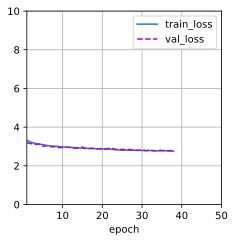

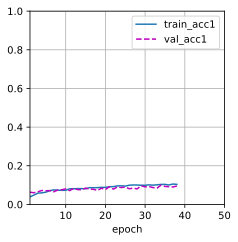

In [29]:
# 初始化画图
animator_loss = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0, 10],
                         legend=['train_loss','val_loss'])
animator_acc = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0, 1],
                        legend=['train_acc1', 'val_acc1'])

def format_time(seconds):
    mins, sec = divmod(seconds, 60)
    hrs, mins = divmod(mins, 60)
    return f"{int(hrs)}h {int(mins)}m {int(sec)}s"

num_epochs = epochs

# 确保保存模型的目录存在
os.makedirs(checkpoint_dir, exist_ok=True)

# 记录训练开始时间（考虑之前已训练的时间）
training_start_time = time.time() - elapsed_time_before

for epoch in range(start_epoch, num_epochs):
    epoch_start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.2e}")

    # 训练
    train_loss, train_acc1 = train_epoch(model, train_loader, criterion, optimizer, scaler, device, accumulation_steps)

    # 验证
    val_loss, acc_1, acc_3, acc_5 = evaluate(model, val_loader, criterion, device)
    
    # 绘图
    animator_loss.add(epoch + 1, [
        train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss,
        val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss
    ])
    animator_acc.add(epoch + 1, [
        train_acc1.item() if isinstance(train_acc1, torch.Tensor) else train_acc1,
        acc_1.item() if isinstance(acc_1, torch.Tensor) else acc_1
    ])

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # 计算剩余时间（考虑之前已训练的时间）
    elapsed_time = epoch_end_time - training_start_time
    avg_epoch_time = elapsed_time / (epoch + 1 - start_epoch + 1e-7)  # 避免除零
    remaining_epochs = num_epochs - (epoch + 1)
    remaining_time = avg_epoch_time * remaining_epochs

    # 转换为更易读的格式
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy@1: {train_acc1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy@1: {acc_1.item():.4f}, Val Accuracy@3: {acc_3.item():.4f}, Val Accuracy@5: {acc_5.item():.4f}")
    print(f"Epoch Duration: {format_time(epoch_duration)}, Estimated Remaining Time: {format_time(remaining_time)}")

    # 更新学习率调度器
    scheduler.step(val_loss)

    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_path = os.path.join(checkpoint_dir, 'multimodal_encoder_decoder_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch+1} to {best_model_path}")
        early_stop_counter = 0  # 重置计数器
    else:
        early_stop_counter += 1  # 增加计数器

    # 如果验证损失连续多个 epoch 没有改善，则停止训练
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break  # 提前停止训练

    # 每隔若干个 epoch 保存模型
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'multimodal_encoder_decoder_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved model at epoch {epoch+1} to {checkpoint_path}")
animator_loss.show()
animator_acc.show()


In [31]:
# 7. 测试评估

# 加载最佳模型
best_model_path = os.path.join(checkpoint_dir, 'multimodal_encoder_decoder_best.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    print("Loaded best model for testing.")
else:
    print(f"Best model not found at {best_model_path}. Skipping test evaluation.")

# 定义测试评估函数（可以与验证相同）


test_loss ,test_acc1 ,test_acc3 ,test_acc5 = evaluate(model,test_loader,criterion,device)
print(f"Test Loss : {test_loss:.4f};Test Accuracy@3 : {test_acc3:.4f}")
print(f"Test Accuracy@1 : {test_acc1:.4f};Test Accuracy@5 : {test_acc5:.4f}")

Loaded best model for testing.


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_70011/3863311555.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.bfloat16):
Evaluating: 100%|██████████| 7/7 [00:16<00:00,  2.32s/it]

Test Loss : 2.7466;Test Accuracy@3 : 0.2463
Test Accuracy@1 : 0.1027;Test Accuracy@5 : 0.3415


## 评估泛化能力

In [32]:
dataset_start_idx_zero = 9
dataset_end_idx_zero = 10
# 定义数据集路径
dataset_path_zero = [f'/data2/wzj/Datasets/DeepSense/scenario{i}/' for i in range(dataset_start_idx_zero, dataset_end_idx_zero)]  # scenario1 ~ scenario8

data_csv_paths_zero = []
for path in dataset_path_zero:
    data_csv_paths_zero.extend(glob.glob(os.path.join(path, '*.csv')))

print(f"Found {len(data_csv_paths_zero)} CSV files for training.")

Found 1 CSV files for training.


In [35]:
zeroshot_dataset = QwenVisionDataset(
    data_csv_paths_zero,
    input_length=8,
    output_length=3
)
zeroshot_dataset[23]

{'video_paths': ['/data2/wzj/Datasets/DeepSense/scenario9/./unit1/camera_resized/image_BS2_2703_16_45_08.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario9/./unit1/camera_resized/image_BS2_2704_16_45_08.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario9/./unit1/camera_resized/image_BS2_2705_16_45_08.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario9/./unit1/camera_resized/image_BS2_2706_16_45_08.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario9/./unit1/camera_resized/image_BS2_2707_16_45_08.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario9/./unit1/camera_resized/image_BS2_2708_16_45_08.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario9/./unit1/camera_resized/image_BS2_2709_16_45_09.jpg',
  '/data2/wzj/Datasets/DeepSense/scenario9/./unit1/camera_resized/image_BS2_2710_16_45_09.jpg'],
 'heatmap_paths': ['/data2/wzj/Datasets/DeepSense/scenario9/./unit1/mmWave_heatmap/mmWave_power_23.png',
  '/data2/wzj/Datasets/DeepSense/scenario9/./unit1/mmWave_heatmap/mmWave_power_24.png',
  '/data2/wzj/Datasets/

In [36]:
cached_zeroshot = CachedVisionDataset(zeroshot_dataset, processor)
zeroshot_dataloader = DataLoader(
    cached_zeroshot,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=partial(collate_fn, device="cpu"),  # 绑定设备参数
    pin_memory=True if device.type == "cuda" else False
)

Caching dataset: 100%|██████████| 5012/5012 [05:34<00:00, 14.96it/s]


In [37]:
zeroshot_loss ,zeroshot_acc_1 ,zeroshot_acc_3 ,zeroshot_acc_5 = evaluate(model,val_loader,criterion,device)
print(f"Zeroshot loss: {zeroshot_loss:.4f}")
print(f"Zeroshot acc@1: {zeroshot_acc_1:.4f}")
print(f"Zeroshot acc@3: {zeroshot_acc_3:.4f}")
print(f"Zeroshot acc@5: {zeroshot_acc_5:.4f}")

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_70011/3863311555.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.bfloat16):
Evaluating: 100%|██████████| 7/7 [00:16<00:00,  2.33s/it]

Zeroshot loss: 2.7685
Zeroshot acc@1: 0.0841
Zeroshot acc@3: 0.2478
Zeroshot acc@5: 0.3467
